In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import os
import torch
import seaborn as sns
import numpy as np
from matplotlib import pyplot
from itertools import product

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.distributions import constraints
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam, LocScaleReparam, HaarReparam, LatentStableReparam
from pyro.optim import Adam, ClippedAdam
from pyro.ops.tensor_utils import convolve

assert pyro.__version__.startswith('1.8.1')

### Data

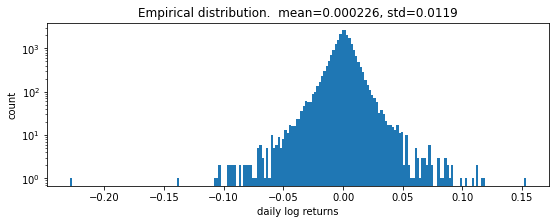

In [9]:
start = 0
df = load_snp500()
dates = df.Date.to_numpy()[start:]
x = torch.tensor(df["Close"]).float()[start:]
r = (x[1:] / x[:-1]).log()

pyplot.figure(figsize=(9, 3))
pyplot.hist(r.numpy(), bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()))
pyplot.show()

### Train utils

In [10]:
class StoreDict(dict):
    def store(self, key, value):
        if key in self:
            self[key].append(value)
        else:
            self[key] = [value]
        
    def store_pyro_params(self):
        for key, value in pyro.get_param_store().items():
            if value.numel() == 1:
                self.store(key, value.squeeze().item())

    def plot(self, key):
        pyplot.figure(figsize=(9, 3))
        pyplot.plot(self[key])
        pyplot.ylabel(key)
        pyplot.xlabel("SVI step")
        pyplot.show()


def train(model, guide, input, num_steps, loss_fn, lr, verbose=True):
    pyro.clear_param_store()
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
    svi = SVI(model, guide, optim, loss_fn)
    store_dict = StoreDict()
    store_dict.store_pyro_params()

    for step in range(num_steps):
        loss = svi.step(**input)
        store_dict.store("loss", loss)
        store_dict.store_pyro_params()

        if verbose and (step % 300 == 0):
            pyplot.show()
            fig = pyplot.figure(figsize=(18, 2))

        if verbose and (step % 100 == 0):
            with torch.no_grad():
                predictive = Predictive(model, guide=guide, num_samples=1, parallel=True)()
                predictive = predictive["r"].flatten()

            ax = fig.add_subplot(1, 3, (step//100)%3+1)
            ax.set_yscale("log")
            ax.hist(r.numpy(), bins=500, alpha=0.5, range=(-0.1, 0.1), label="data")
            ax.hist(predictive.numpy(), bins=500, alpha=0.5, range=(-0.1, 0.1), label="samples")
            ax.set_title("Epoch {}".format(step))
            ax.legend()

    if verbose:
        store_dict.plot("loss")
        for key, value in store_dict.items():
            if key != "loss":
                print("{} = {:0.4g}".format(key, value[-1]))

    return store_dict

### MLE

In [11]:
def model(data=None):
    stability = pyro.param("stability", torch.tensor(1.2), constraint=constraints.interval(0, 2))
    skew = pyro.param("skew", torch.tensor(0.0), constraint=constraints.interval(-1, 1))
    scale = pyro.param("scale", torch.tensor(0.008), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.0))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=data)

def empty_guide(data=None):
    pass

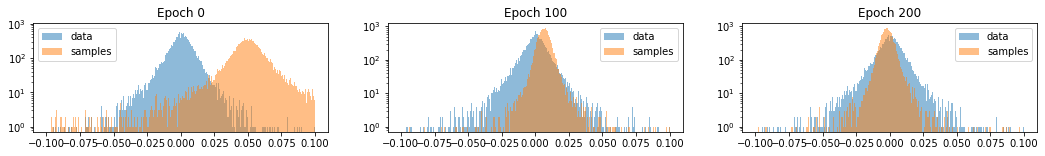

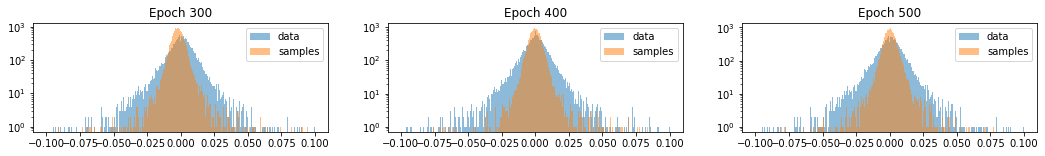

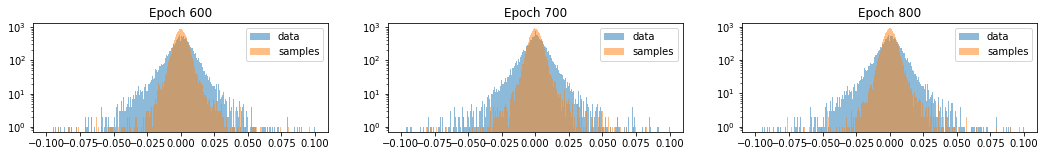

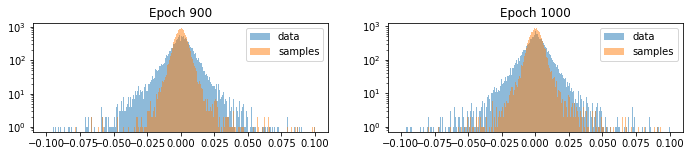

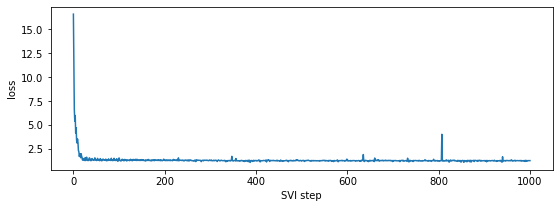

stability = 1.665
skew = 0.1303
scale = 0.003063
loc = 0.0001321


In [7]:
_ = train(model, empty_guide, input={"data": r}, num_steps=1001, loss_fn=EnergyDistance(), lr=5e-2)

### MAP
- Model and guide

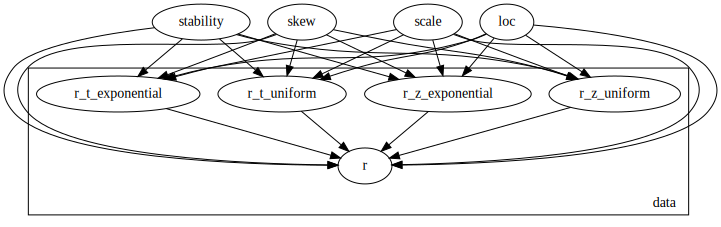

In [39]:
def get_model(reparam=False):
    def model(data=None):
        stability = pyro.sample("stability", dist.Uniform(1, 2))
        skew = pyro.sample("skew", dist.Uniform(-1e-2, 1e-2))
        scale = pyro.sample("scale", dist.Uniform(0, 1e-2))
        loc = pyro.sample("loc", dist.Normal(0, 1e-2))
        with pyro.plate("data", len(r)):
            return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=data)
    return poutine.reparam(get_model(), {"r": StableReparam()}) if reparam else model

pyro.render_model(get_model(reparam=True))

In [43]:
class TruncatedNormal(dist.Rejector):
    def __init__(self, loc, scale, min_x, max_x):
        propose = dist.Normal(loc, scale)
        def log_prob_accept(x):
            return torch.logical_and(x >= min_x, x <= max_x).type_as(x).log()
        log_scale = torch.log(propose.cdf(max_x) - propose.cdf(min_x))
        super(TruncatedNormal, self).__init__(propose, log_prob_accept, log_scale)


def get_guide(reparam=False):
    def guide(data=None):
        stability_mean = pyro.param("stability_mean", torch.tensor(1.5), constraint=constraints.interval(1, 2))
        skew_mean = pyro.param("skew_mean", torch.tensor(0.0), constraint=constraints.interval(-1e-2, 1e-2))
        scale_mean = pyro.param("scale_mean", torch.tensor(0.005), constraint=constraints.interval(0, 1e-2))
        loc_mean = pyro.param("loc_mean", torch.tensor(0.0))

        stability_var = pyro.param("stability_var", torch.tensor(0.01), constraint=constraints.softplus_positive)
        skew_var = pyro.param("skew_var", torch.tensor(0.0001), constraint=constraints.softplus_positive)
        scale_var = pyro.param("scale_var", torch.tensor(0.0001), constraint=constraints.softplus_positive)
        loc_var = pyro.param("loc_var", torch.tensor(0.0001), constraint=constraints.softplus_positive)

        stability = pyro.sample("stability", TruncatedNormal(stability_mean, stability_var, torch.tensor(0.0), torch.tensor(2.0)))
        skew = pyro.sample("skew", TruncatedNormal(skew_mean, skew_var, torch.tensor(-1.0), torch.tensor(1.0)))
        scale = pyro.sample("scale", TruncatedNormal(scale_mean, scale_var, torch.tensor(0.0), torch.tensor(1e-2)))
        loc = pyro.sample("loc", dist.Normal(loc_mean, loc_var))

        if reparam:
            with pyro.plate("data", len(r)):
                r_z_uniform = pyro.sample("r_z_uniform", dist.Uniform(-torch.pi/2, torch.pi/2))
                r_z_exponential = pyro.sample("r_z_exponential", dist.Exponential(1.0))
                r_t_uniform = pyro.sample("r_t_uniform", dist.Uniform(-torch.pi/2, torch.pi/2))
                r_t_exponential = pyro.sample("r_t_exponential", dist.Exponential(1.0))
    
    return guide

- EnergyDistance, without reparam

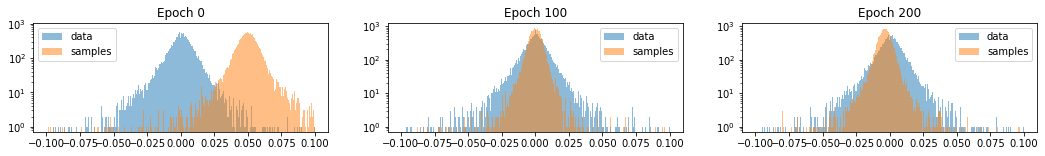

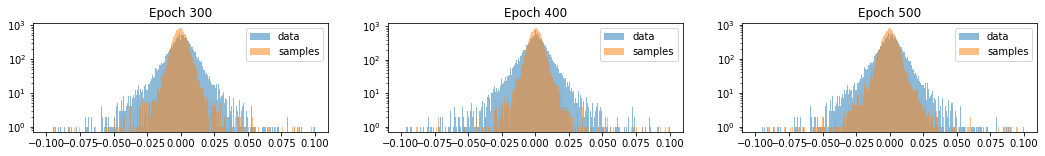

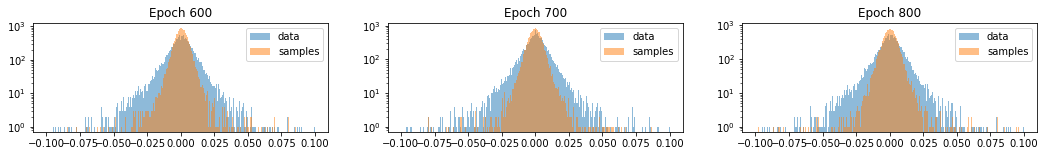

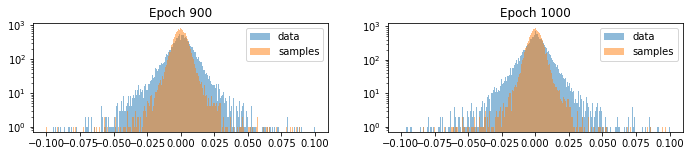

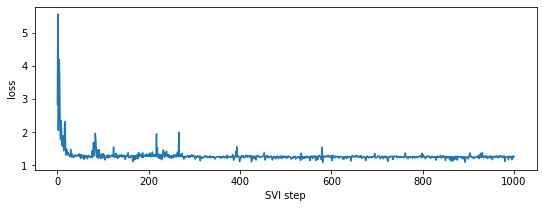

stability_mean = 1.683
skew_mean = -0.0005525
scale_mean = 0.003282
loc_mean = 0.0001181
stability_var = 0.01217
skew_var = 0.0001005
scale_var = 6.334e-05
loc_var = 3.934e-05


In [44]:
model = get_model(reparam=False)
guide = get_guide(reparam=False)
_ = train(model, guide, input={"data": r}, num_steps=1001, loss_fn=EnergyDistance(prior_scale=0.001), lr=5e-2)

- Trace_ELBO, with reparam

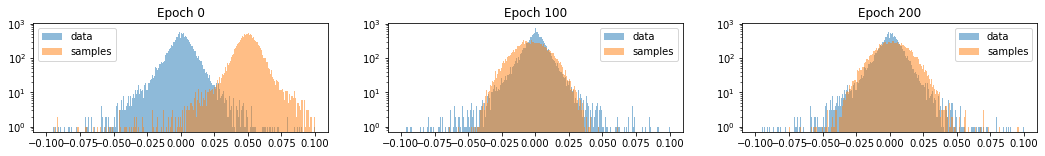

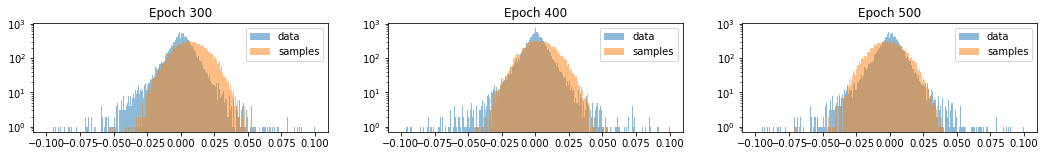

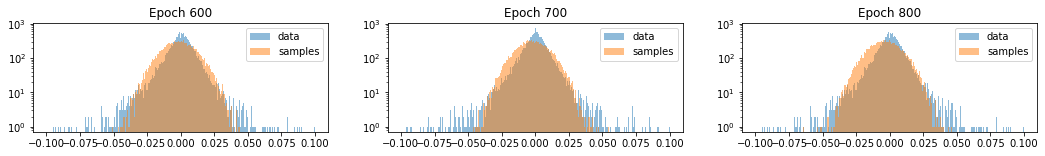

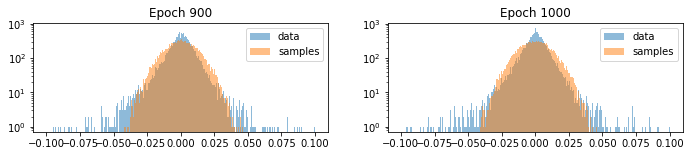

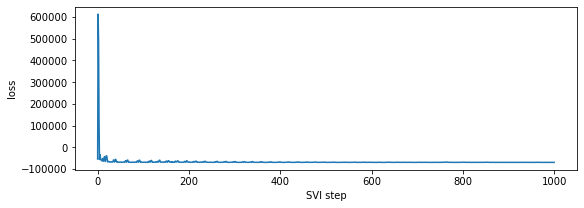

stability_mean = 2
skew_mean = -9.521e-05
scale_mean = 0.008422
loc_mean = -7.13e-05
stability_var = 0.001316
skew_var = 0.0001179
scale_var = 3.942e-05
loc_var = 0.0001102


In [45]:
model = get_model(reparam=True)
guide = get_guide(reparam=True)
_ = train(model, guide, input={"data": r}, num_steps=1001, loss_fn=Trace_ELBO(), lr=5e-2)

- EnergyDistance, with reparam

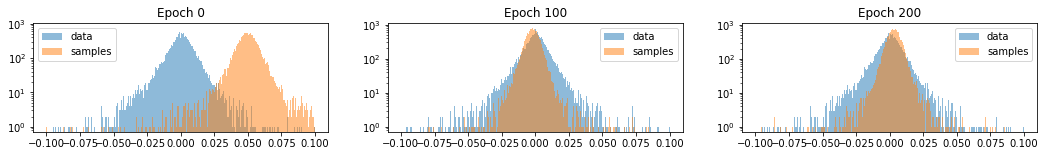

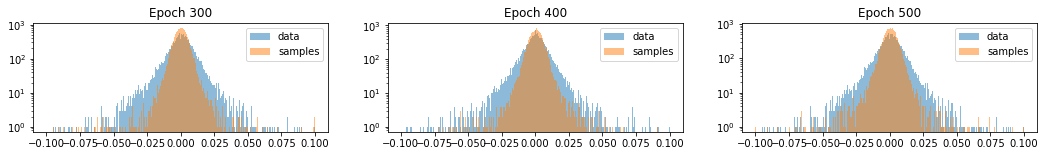

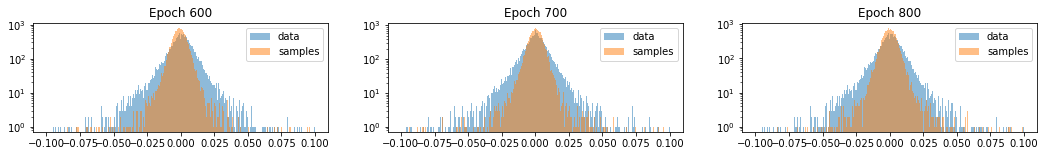

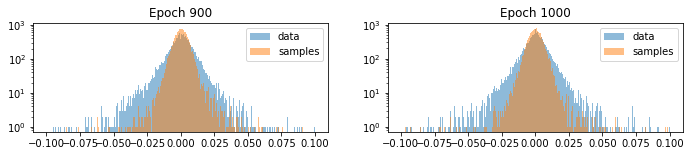

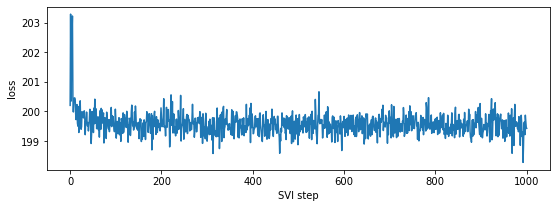

stability_mean = 1.706
skew_mean = -0.005459
scale_mean = 0.0034
loc_mean = 5.767e-05
stability_var = 0.004282
skew_var = 0.0001141
scale_var = 4.499e-05
loc_var = 0.0001694


In [46]:
model = get_model(reparam=True)
guide = get_guide(reparam=True)
_ = train(model, guide, input={"data": r}, num_steps=1001, loss_fn=EnergyDistance(prior_scale=0.001), lr=5e-2)

### MLEs converge very slowly

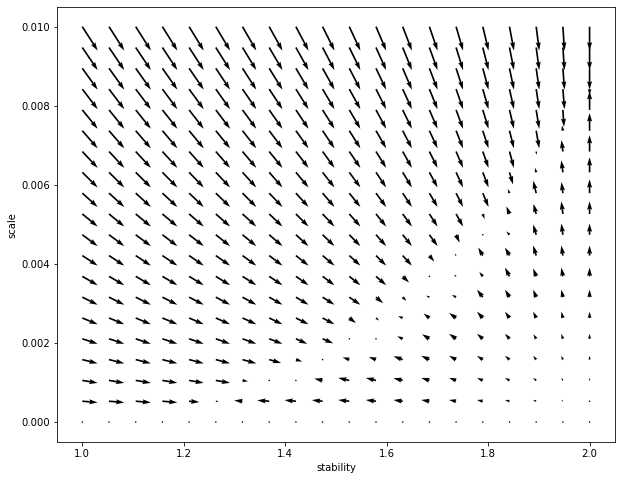

In [7]:
import warnings
warnings.filterwarnings('ignore')

def init_model(stability_init, scale_init):
    def model(data=None):
        stability = pyro.param("stability", torch.tensor(stability_init), constraint=constraints.interval(0, 2))
        scale = pyro.param("scale", torch.tensor(scale_init), constraint=constraints.positive)
        with pyro.plate("data", len(r)):
            return pyro.sample("r", dist.Stable(stability, 0.0, scale, 0.0), obs=data)
    return model

xs, ys = np.linspace(1.0, 2, 20), np.linspace(0, 0.01, 20)
us, vs = [], []

for x, y in product(xs, ys):
    try:
        u, v = [], []
        for _ in range(20):
            model = init_model(x, y)
            store_dict = train(model, empty_guide, input={"data": r}, num_steps=1, loss_fn=EnergyDistance(), lr=1e-2, verbose=False)
            u.append(store_dict["stability"][-1] - x)
            v.append(store_dict["scale"][-1] - y)

        us.append(sum(u) / len(u))
        vs.append(sum(v) / len(v))

    except: # Nan errors
        us.append(0.0)
        vs.append(0.0)

xs, ys = np.meshgrid(xs, ys)
us, vs = np.array(us), np.array(vs)
us[np.isnan(us)] = 0.0
vs[np.isnan(vs)] = 0.0
us = us.reshape(xs.shape).T
vs = vs.reshape(ys.shape).T

pyplot.figure(figsize=(10, 8))
pyplot.quiver(xs, ys, us, vs, angles='xy', scale_units='xy')
pyplot.xlabel("stability")
pyplot.ylabel("scale")
pyplot.show()

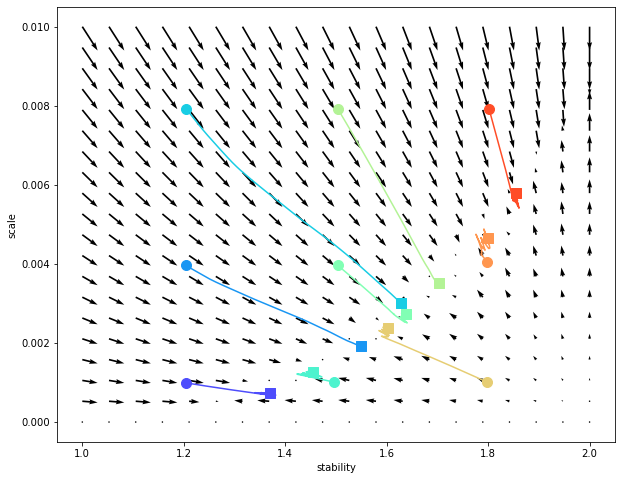

In [11]:
# Results with 1001 steps
pyplot.figure(figsize=(10, 8))
pyplot.quiver(xs, ys, us, vs, angles='xy', scale_units='xy')
pyplot.xlabel("stability")
pyplot.ylabel("scale")

stability_inits = [1.2, 1.5, 1.8]
scale_inits = [0.001, 0.004, 0.008]
colors = iter(pyplot.cm.rainbow(np.linspace(0.1, 0.9, 9)))

for stability_init, scale_init in product(stability_inits, scale_inits):
    model = init_model(stability_init, scale_init)
    store_dict = train(model, empty_guide, input={"data": r}, num_steps=1001, loss_fn=EnergyDistance(), lr=1e-2, verbose=False)
    color = next(colors)
    pyplot.scatter(store_dict["stability"][0], store_dict["scale"][0], color=color, s=100)
    pyplot.scatter(store_dict["stability"][-1], store_dict["scale"][-1], color=color, s=100, marker="s")
    pyplot.plot(store_dict["stability"], store_dict["scale"], color=color)

pyplot.show()

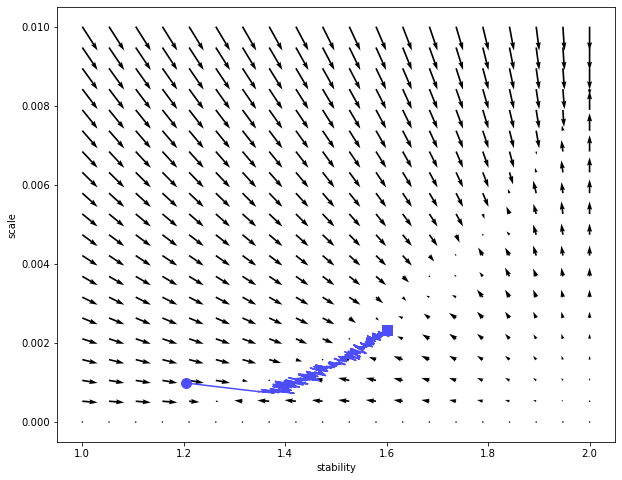

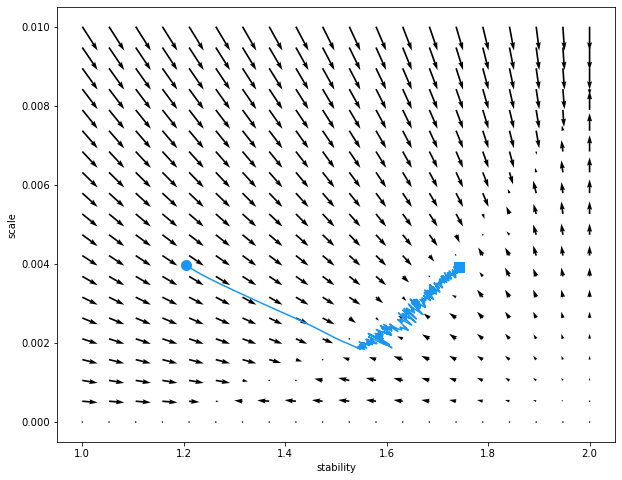

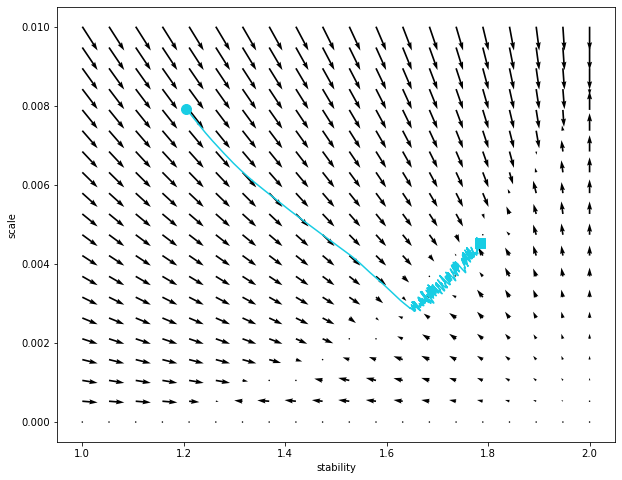

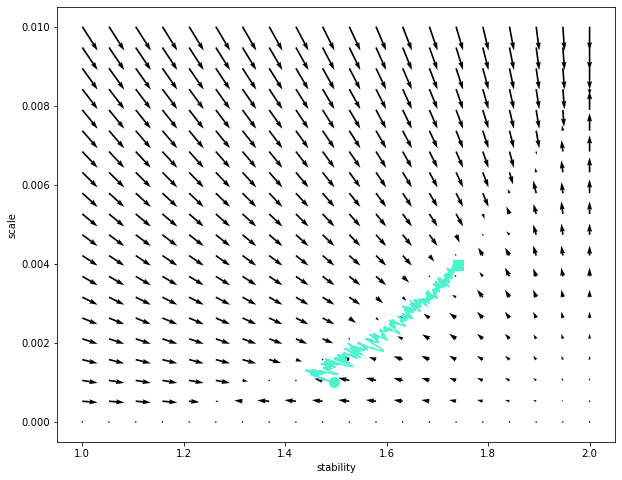

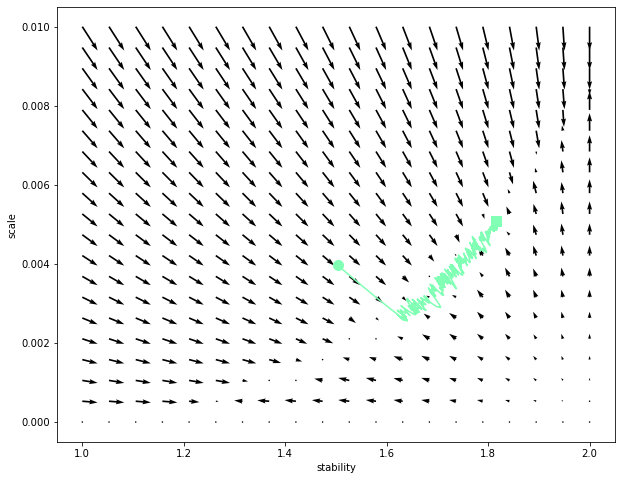

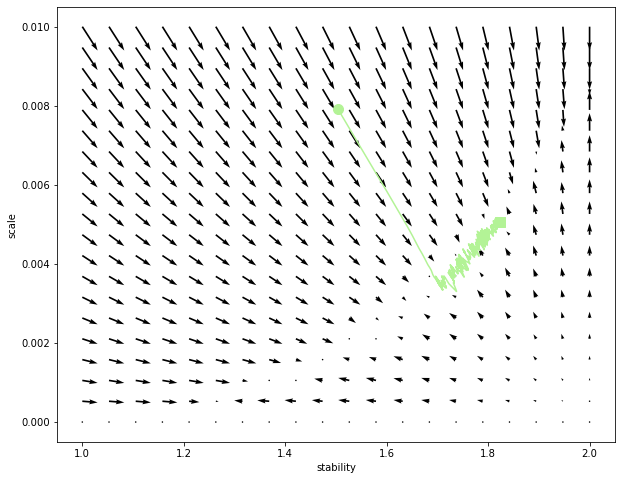

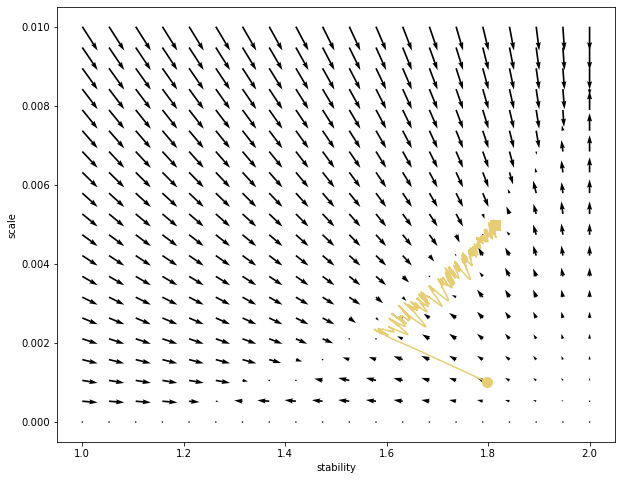

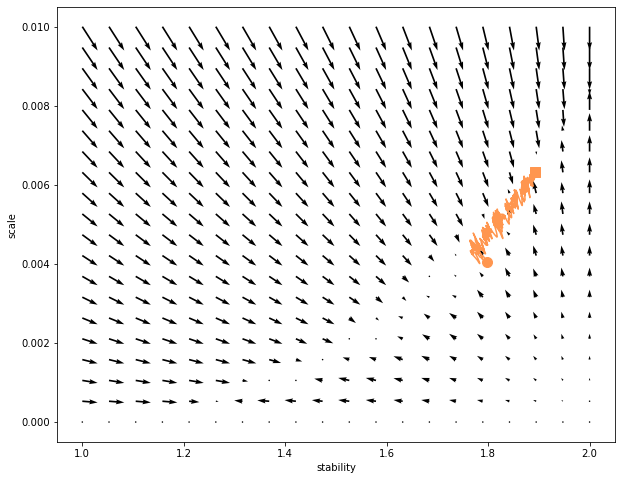

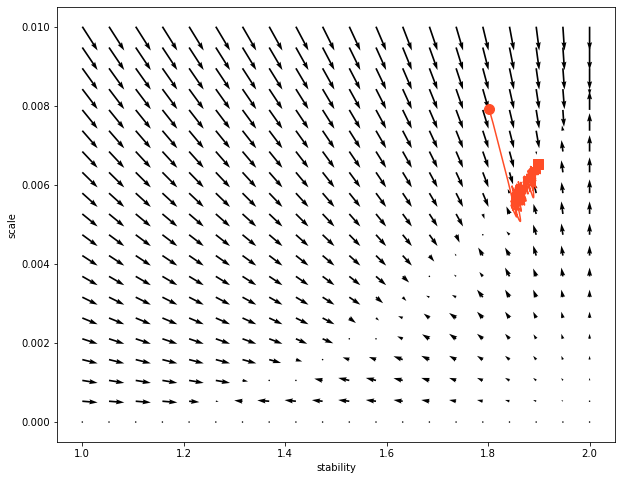

In [9]:
# Results with 20001 steps
stability_inits = [1.2, 1.5, 1.8]
scale_inits = [0.001, 0.004, 0.008]
colors = iter(pyplot.cm.rainbow(np.linspace(0.1, 0.9, 9)))

for stability_init, scale_init in product(stability_inits, scale_inits):
    model = init_model(stability_init, scale_init)
    store_dict = train(model, empty_guide, input={"data": r}, num_steps=20001, loss_fn=EnergyDistance(), lr=1e-2, verbose=False)
    color = next(colors)
    
    pyplot.figure(figsize=(10, 8))
    pyplot.quiver(xs, ys, us, vs, angles='xy', scale_units='xy')
    pyplot.xlabel("stability")
    pyplot.ylabel("scale")
    pyplot.scatter(store_dict["stability"][0], store_dict["scale"][0], color=color, s=100)
    pyplot.scatter(store_dict["stability"][-1], store_dict["scale"][-1], color=color, s=100, marker="s")
    pyplot.plot(store_dict["stability"], store_dict["scale"], color=color)
    pyplot.show()

### Reparametrisation and autoguides force non-parametrised models to learn

In [47]:
# Poorly fixed stable model
def get_poor_model(reparam=False):
    def poor_model(data=None):
        stability = 0.9
        skew = -1.0
        scale = 0.1
        loc = 0.1
        with pyro.plate("data", len(r)):
            return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=data)
    return poutine.reparam(poor_model, {"r": StableReparam()}) if reparam else poor_model

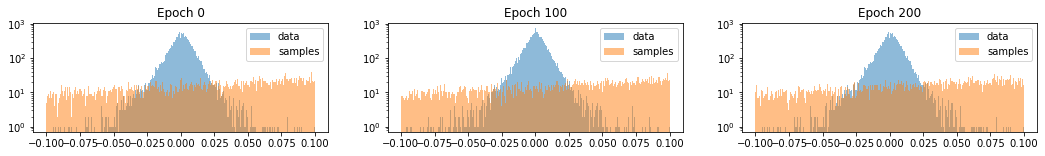

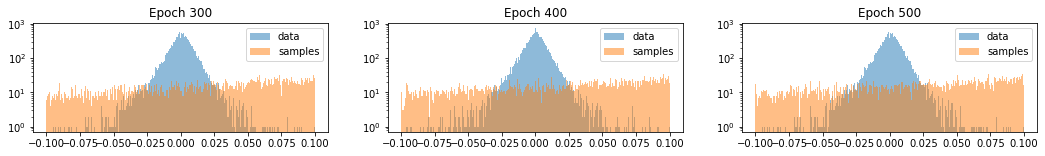

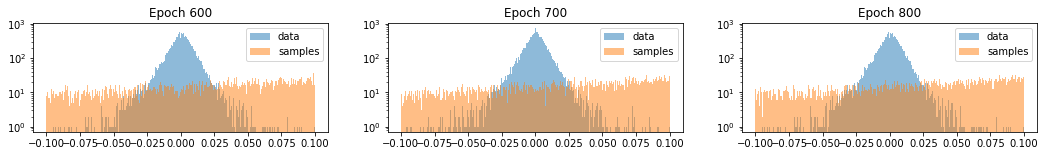

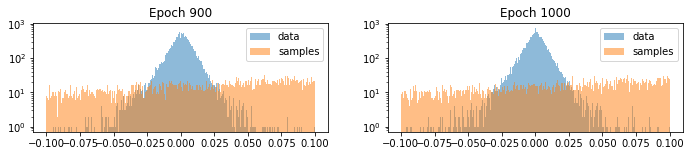

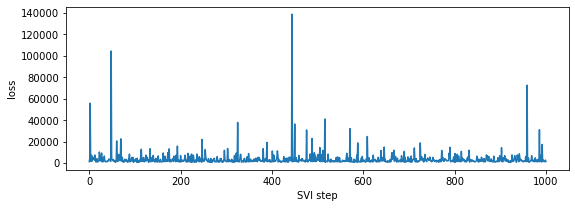

In [63]:
# Poor fit as expected
model = get_poor_model(reparam=False)
_ = train(model, empty_guide, input={"data": r}, num_steps=1001, loss_fn=EnergyDistance(), lr=1e-1)

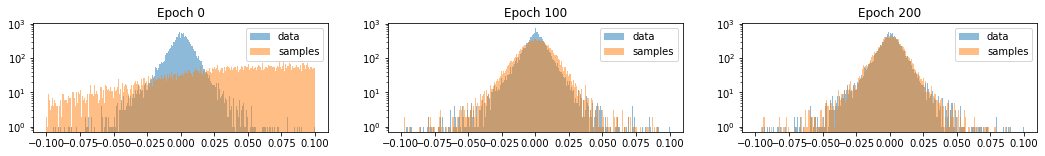

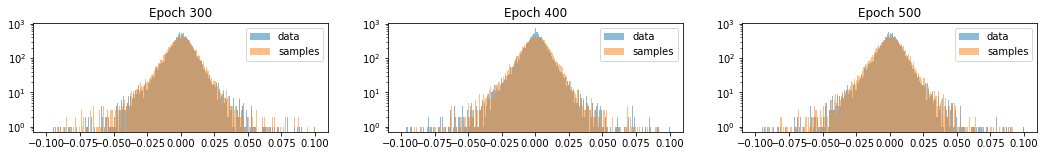

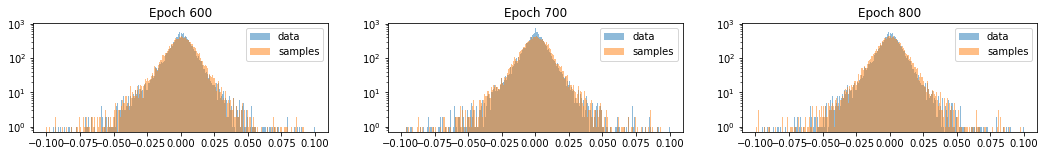

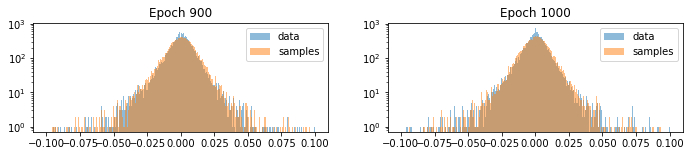

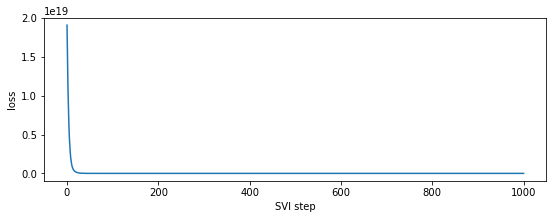

In [62]:
# Reparam and autoguide force it to learn
model = get_poor_model(reparam=True)
guide = AutoDiagonalNormal(model)
_ = train(model, guide, input={"data": r}, num_steps=1001, loss_fn=Trace_ELBO(), lr=5e-2)

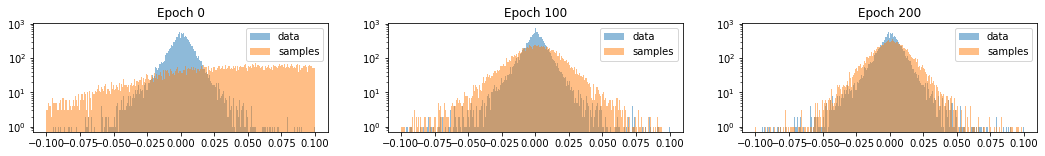

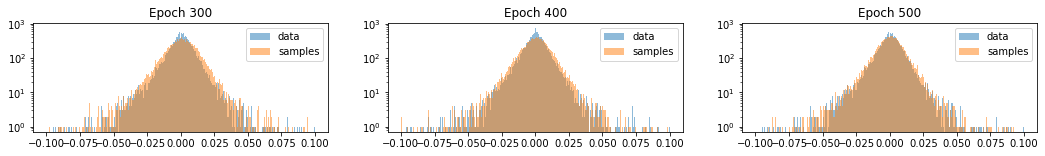

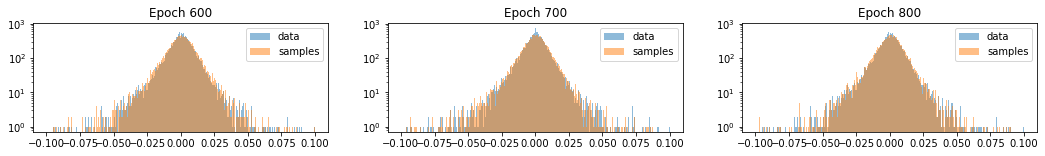

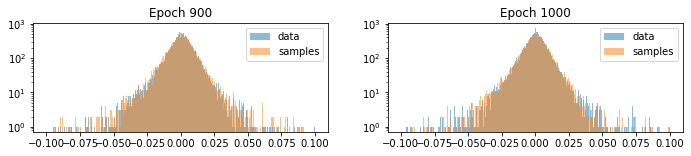

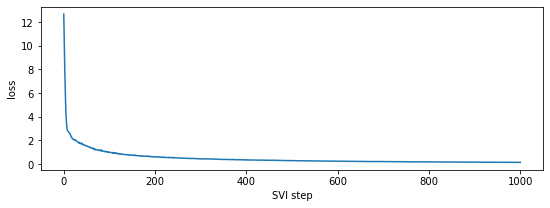

In [61]:
# Reparam and autoguide force it to learn
model = get_poor_model(reparam=True)
guide = AutoDiagonalNormal(model)
_ = train(model, guide, input={"data": r}, num_steps=1001, loss_fn=EnergyDistance(), lr=1e-1)